# Forecasting

Importiamo le librerie necessarie e definiamo il path dove stanno i dataset

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
path = r".\\DataSet\\"
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import sklearn.metrics as met

Apriamo il csv contenente i dati, convertiamo la data e raggruppiamo per giorno i risultati delle varie stazioni alle varie ore del giorno, facendone la media.

In [2]:
allMadrid = pd.read_csv(path+"out.csv")
allMadrid['date'] = pd.to_datetime(allMadrid['date'])
allMadrid['date']=allMadrid['date'].dt.normalize()
allMadrid=allMadrid.groupby(['date']).mean().drop(columns=['station'])
display(allMadrid)

,BEN,CO,EBE,NMHC,NO,NO_2,O_3,PM10,PM25,SO_2,TCH,TOL
date,,,,,,,,,,,,
2008-01-01,1.314348,0.652554,1.040163,0.314783,11.820078,67.084565,9.280977,39.855419,25.650870,19.815357,1.656304,4.026522
2008-01-02,1.128177,0.531806,1.016719,0.270625,11.820078,66.552372,9.750819,21.005401,15.767895,14.897970,1.536750,3.857708
2008-01-03,0.727969,0.360000,0.942292,0.229083,11.820078,50.410930,30.313847,9.173423,5.617396,10.923919,1.400333,2.911875
2008-01-04,0.907969,0.458993,1.062031,0.257647,11.820078,58.247292,20.756432,21.390939,13.236000,12.875144,1.409706,4.055104
2008-01-05,0.823750,0.389635,0.785260,0.238250,11.820078,47.282292,20.405407,18.745682,12.485729,11.804503,1.482792,3.244219
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-27,0.364583,0.249583,0.443750,0.062639,7.756522,26.074783,65.695783,26.278317,10.256944,3.677966,1.340833,1.625000
2018-04-28,0.216667,0.212917,0.194444,0.055000,2.824653,13.512153,71.706587,10.971154,5.930556,3.604167,1.300556,0.691667
2018-04-29,0.193750,0.218333,0.133333,0.053194,2.333333,11.098958,78.044643,6.955128,3.229167,3.591667,1.289861,0.370833


In [3]:
allMadrid.isnull().sum()

BEN        0
CO         0
EBE        0
NMHC       0
NO         0
NO_2       0
O_3        0
PM10       0
PM25       0
SO_2       0
TCH        0
TOL        0
station    0
dtype: int64

## NO2

Prendiamo i dati relativi al NO2 e stampiamo il suo andamento

<AxesSubplot: xlabel='date'>

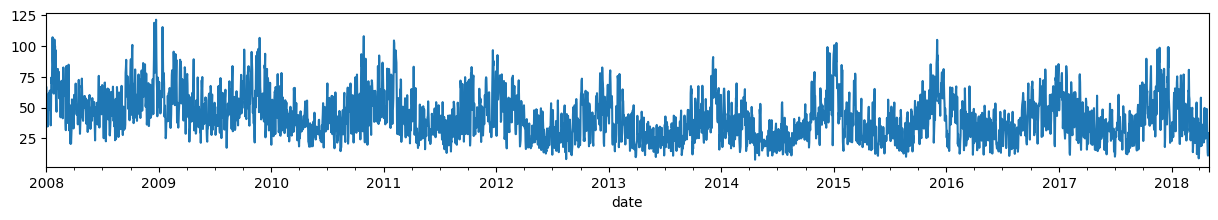

In [3]:
forNo = allMadrid['NO_2']
forNo.plot(figsize=(15, 2))

### Augmented dickey fuller test (Stazionarietà)

In [5]:
X2 = forNo.values
result2 = adfuller(X2)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.235168
p-value: 0.000007
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Stagionalità, trend e residui

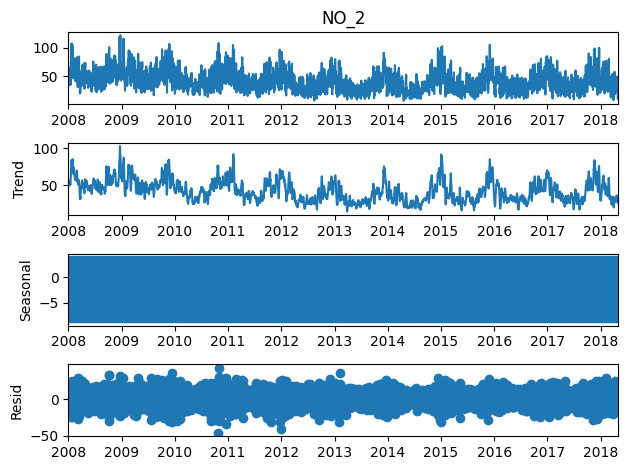

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec2 = seasonal_decompose(forNo, model='additive')
dec2.plot()
plt.show()

### Autocorrelazione e Autocorrelazione parziale

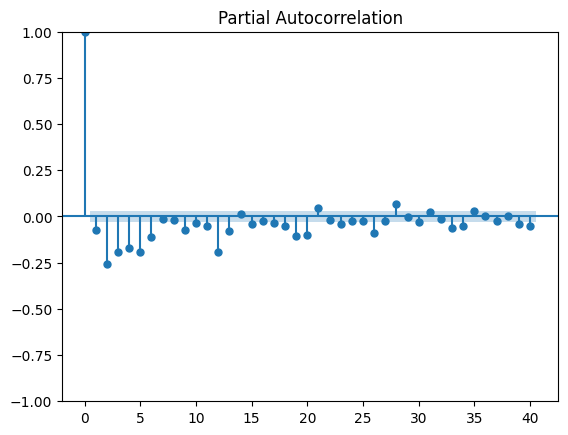

In [7]:
sm.graphics.tsa.plot_pacf(forNo.diff().dropna(), lags=40, method="ywm")
plt.show()

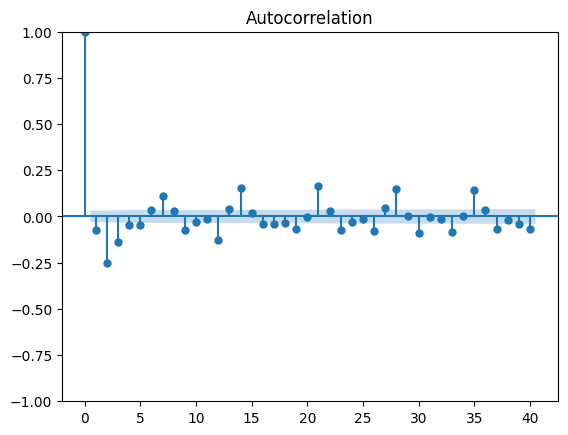

In [8]:
sm.graphics.tsa.plot_acf(forNo.diff().dropna(), lags=40)
plt.show()

### Modello per predizione

In [ ]:
nobs = len(forNo)
n_init_training = int(nobs * 0.8)

# Creiamo il modello per il training
init_training_forNo = forNo[:n_init_training]
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(init_training_forNo, order=(0,0,0), seasonal_order=(5,1,5,12)) 
ax = plt.gca()
results_80 = model.fit() 
plt.plot(forNo[:n_init_training], color='limegreen')
plt.plot(forNo[n_init_training-1:], color='deepskyblue')
plt.plot(results_80.fittedvalues, color='hotpink')
ax.legend(['Training Set', 'Test Set','Forecast'])

print(results_80.summary())
print("Il numero degli elementi del periodo considerato è: "+str(nobs))
print("L'indice dell'ultimo elemento del training set è: "+str(n_init_training))

In [4]:
last_period=forNo['2011-06-01':]
nobs_last = len(last_period)
n_init_training_last = int(nobs_last * 0.8)

# Creiamo il modello per il training
init_training_last = last_period[:n_init_training_last]
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model_last = ARIMA(init_training_last, order=(0,0,0), seasonal_order=(5,1,5,12)) 
ax = plt.gca()
results_last = model_last.fit() 
plt.plot(forNo, color='k')
plt.plot(last_period[:n_init_training_last], color='limegreen')
plt.plot(last_period[n_init_training_last-1:], color='deepskyblue')
plt.plot(results_last.fittedvalues, color='hotpink')
ax.legend(['Dati \'scartati\'','Training Set', 'Test Set','Forecast'])

print(results_last.summary())
print("Il numero degli elementi del periodo considerato è: "+str(nobs_last))
print("L'indice dell'ultimo elemento del training set è: "+str(n_init_training_last))

d:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Predizione in-sample

In [ ]:
fig = plt.figure(figsize=(20,8))
x2 = results_80.get_prediction(start=(n_init_training+1), end=(nobs-1)).summary_frame()

plt.plot(init_training_forNo[2400:], color='limegreen')
plt.plot(forNo[n_init_training+1:],color='deepskyblue')
plt.plot(x2['mean'], color='hotpink')
plt.legend([ 'Training Set','Test Set', 'Forecast'])
plt.fill_between(x2.index, x2['mean_ci_lower'], x2['mean_ci_upper'], color='hotpink', alpha=0.3)

In [ ]:
fig = plt.figure(figsize=(20,8))
x_last = results_last.get_prediction(start=(n_init_training_last+1), end=(nobs_last-1)).summary_frame()

plt.plot(last_period[:n_init_training_last], color='limegreen')
plt.plot(last_period[n_init_training_last+1:],color='deepskyblue')
plt.plot(x_last['mean'], color='hotpink')
plt.legend([ 'Training Set','Test Set', 'Forecast'])
plt.fill_between(x_last.index, x_last['mean_ci_lower'], x_last['mean_ci_upper'], color='hotpink', alpha=0.3)

Metriche valutazione della predizione in-sample

In [ ]:
Y_actual2 = forNo[n_init_training+1:]
Y_Predicted2 = x2['mean']
mape2 = met.mean_absolute_percentage_error(Y_actual2, Y_Predicted2)
print(mape2)

In [ ]:
Y_actual_last = last_period[n_init_training_last+1:]
Y_Predicted_last = x_last['mean']
mape_last = met.mean_absolute_percentage_error(Y_actual_last, Y_Predicted_last)
print(mape_last)

In [ ]:
sqe=met.mean_squared_error(Y_actual2, Y_Predicted2)
print(sqe)

In [ ]:
sqe_last=met.mean_squared_error(Y_actual_last, Y_Predicted_last)
print(sqe_last)

In [ ]:
mae = met.mean_absolute_error(Y_actual2, Y_Predicted2)
print(mae)

In [ ]:
mae_last = met.mean_absolute_error(Y_actual_last, Y_Predicted_last)
print(mae_last)

In [ ]:
r2 = met.r2_score(Y_actual2, Y_Predicted2)
print(r2)

In [ ]:
r2_last = met.r2_score(Y_actual_last, Y_Predicted_last)
print(r2_last)

### Predizione out-sample

In [ ]:
fig3, ax3 = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
forNo['2017-12-01':].plot(ax=ax3, color='darkorange')

# Construct the forecasts
fcast = results_80.get_prediction(start=(nobs), end=(nobs+60)).summary_frame()
fcast['mean'].plot(ax=ax3, style='--', color='hotpink')
ax3.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='hotpink', alpha=0.3)
ax3.legend(['Dataset', 'Forecast'])

In [ ]:
fig3, ax3 = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
forNo['2017-12-01':].plot(ax=ax3, color='darkorange')

# Construct the forecasts
fcast_last = results_last.get_prediction(start=(nobs_last), end=(nobs_last+60)).summary_frame()
fcast_last['mean'].plot(ax=ax3, style='--', color='hotpink')
ax3.fill_between(fcast_last.index, fcast_last['mean_ci_lower'], fcast_last['mean_ci_upper'], color='hotpink', alpha=0.3)
ax3.legend(['Dataset', 'Forecast'])